In [ ]:
""" This notebook extracts MMSE values from PET metadata. As it turned out, a lot of them are missing and
extracting them from Merge yielded a much higher sample, and that sample is the one USED IN THE PAPER.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nibabel
import nibabel.processing
import os
from skimage.filters import threshold_otsu
import cc3d
import shutil
import pickle
import pandas as pd
import xml.etree.cElementTree as et

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm, trange
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#USE SMALL GPU#
use_gpu = 1 
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

In [4]:
#Borrowed from the 3D preprocessing

def normalize(volume):
    """Normalize the volume"""
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def pp(original_image):
    
    input_img=input_img = nibabel.load("{0}".format(original_image))
    resampled_img = nibabel.processing.conform(input_img, out_shape=(100,100,90), voxel_size=(2.0, 2.0, 2.0))
    
    img = resampled_img.get_fdata()
    
    thresh = threshold_otsu(img)
    bw_img1 = np.copy(img)
    bw_img1[bw_img1 < thresh] = 0
    bw_img1[bw_img1 >= thresh] = 255
    
    input_CCA=bw_img1.astype('int32')
    connectivity = 6
    labels_out, N = cc3d.connected_components(input_CCA, return_N=True)
    
    def mask_largest_label (labels_out, N):
        #print("This function returns the largest blob of a CCA processed image as a binary mask")
        #print("")
        def separate_labels(label_ID, label_matrix):
            mask=1*(label_matrix == label_ID)
            return mask
        labellist=[]
        for j in range(1, N+1):
            a=separate_labels(j, labels_out)
            labellist.append(a)
        #print("The image has {0} labels".format(len(labellist)))
        z=labellist[0]
        #print("The shape of the labels is: {0}".format(z.shape))
        sizelist=[]
        for counter,element in enumerate (labellist):
            a=labellist[counter].sum()
            sizelist.append(a)
        #print("Label sizes: {0}".format(sizelist))
        sizelist=np.asarray(sizelist)
        a=sizelist.argmax()
        #print("The largest label index is: {0}".format(a))
        mask=labellist[a]
        #print("The largest label is now a binary mask with shape {0}, size {1}, max value {2} and min value {3}".format((mask.shape),(mask.sum()),(mask.max()),(mask.min())))
        return mask

    mask=mask_largest_label(labels_out, N)
    
    pimg=np.multiply(img,mask)
    
    return pimg

def process(path):
    """Read and normalize volume"""
    # Read and pp scan
    volume = pp(path)
    # Normalize
    volume = normalize(volume)
    #Prepare for NN input
    volume = np.expand_dims(volume, axis=0)
    volume = np.expand_dims(volume, axis=4)
    return volume

In [5]:
def get_preds(modeldir,directory):
    model=tf.keras.models.load_model(modeldir)
    dire=directory
    
    predictdict={}
    for i in tqdm(os.listdir(dire), desc='Prediction making'):
        volume=process(os.path.join(dire,'{}'.format(i)))
        prediction=model.predict(volume)
        predictdict.update({'{}'.format(i): float(prediction)})
    pdpred=pd.DataFrame.from_dict(data=predictdict, orient="index", columns=["pred"])
    
    return pdpred

In [7]:
#This loop extracts MMSE information from MCI patients in the set, stores it in a dictionary

mmsedic={}
r=0
for root, dirs, files in os.walk("/local_mount/space/celer/1/users/david/Datasets/new_ADNI/ADNI/"):
    for file in files:
        if root=="/local_mount/space/celer/1/users/david/Datasets/new_ADNI/ADNI/":
            print("Base directory, nothing to do here")
        
        elif r!=root:
            #print(root)
            os.chdir(root)
            try:
                if len(os.listdir())>2:
                    %cd -q .. 
                    key=os.listdir()[0]
            
                    for element in os.listdir("/local_mount/space/celer/1/users/david/Datasets/new_ADNI/ADNI/"):
                        if key in element:
                            #print("Got the key!",element)
                            tree=et.parse(os.path.join("/local_mount/space/celer/1/users/david/Datasets/new_ADNI/ADNI/",element))
                            raiz=tree.getroot()
                            for group in raiz.iter("researchGroup"):
                                a=group.text
                                print("Class is: ",a)
                    
                    %cd -q ..
                    %cd -q ..
                    pat=os.getcwd()
                    name=os.path.basename(pat)
                    
                    
                    if "MCI" in a:
                        for element in os.listdir("/local_mount/space/celer/1/users/david/Datasets/new_ADNI/ADNI/"):
                            if key in element:
                                try:
                                    #print("Got the key!",element)
                                    tree=et.parse(os.path.join("/local_mount/space/celer/1/users/david/Datasets/new_ADNI/ADNI/",element))
                                    raiz=tree.getroot()
                                    a=[]
                                    for group in raiz.iter("assessmentScore"):
                                        a.append(group.text)
                                        print(group.text)
                                    if float(a[0])>10:
                                        print("MMSE is:", a[0])
                                        mmsedic.update({'{0}_{1}.nii'.format(name,key): float(a[0])})
                                    else:
                                        print("Other scales no MMSE")
                                except:
                                    print("No scales in this one")
                    
                else:
                    print("No images in this directory")
            except Exception as e:
                print("Error in the pipeline")
                print(e)
                mistakes.append(root)
                
        r=root
        

Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, nothing to do here
Base directory, noth

Class is:  MCI
30.0
3.0
0.5
2.0
4.0
MMSE is: 30.0
Class is:  MCI
30.0
3.0
0.5
1.0
1.0
MMSE is: 30.0
Class is:  MCI
3.0
2.0
Other scales no MMSE
Class is:  MCI
29.0
0.5
2.0
3.0
MMSE is: 29.0
Class is:  MCI
30.0
4.0
0.5
2.0
3.0
MMSE is: 30.0
Class is:  AD
No images in this directory
Class is:  CN
Class is:  CN
No images in this directory
Class is:  CN
Class is:  AD
Class is:  MCI
26.0
1.0
7.0
8.0
MMSE is: 26.0
Class is:  MCI
21.0
0.0
1.0
7.0
12.0
MMSE is: 21.0
Class is:  MCI
27.0
0.5
0.0
0.0
MMSE is: 27.0
Class is:  MCI
25.0
0.0
0.5
3.0
7.0
MMSE is: 25.0
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  MCI
22.0
0.5
0.0
8.0
MMSE is: 22.0
Class is:  MCI
24.0
0.0
0.5
2.0
1.0
MMSE is: 24.0
Class is:  MCI
23.0
1.0
0.5
3.0
12.0
MMSE is: 23.0
Class is:  MCI
0.0
7.0
Other scales no MMSE
Class is:  MCI
28.0
0.5
1.0
8.0
MMSE is: 28.0
Class is:  MCI
No scales in this one
No images in this directory
Class is:  CN
Class is:  AD
Class is:  MC

Class is:  MCI
20.0
4.0
0.5
0.0
4.0
MMSE is: 20.0
Class is:  MCI
27.0
0.5
1.0
2.0
MMSE is: 27.0
Class is:  MCI
24.0
0.5
1.0
7.0
MMSE is: 24.0
Class is:  MCI
19.0
1.0
0.5
1.0
18.0
MMSE is: 19.0
Class is:  MCI
0.0
2.0
Other scales no MMSE
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  AD
No images in this directory
No images in this directory
No images in this directory
No images in this directory
No images in this directory
No images in this directory
Class is:  MCI
29.0
1.0
0.0
1.0
8.0
MMSE is: 29.0
Class is:  AD
No images in this directory
Class is:  MCI
1.0
1.0
Other scales no MMSE
Class is:  MCI
21.0
0.5
3.0
1.0
MMSE is: 21.0
Class is:  MCI
18.0
1.0
15.0
15.0
MMSE is: 18.0
Class is:  MCI
18.0
1.0
0.5
10.0
11.0
MMSE is: 18.0
Class is:  MCI
12.0
1.0
1.0
15.0
19.0
MMSE is: 12.0
Class is:  CN
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
No images in this directory
Class is:  AD
Class is:

Class is:  MCI
26.0
0.0
1.0
12.0
13.0
MMSE is: 26.0
Class is:  MCI
25.0
1.0
1.0
13.0
18.0
MMSE is: 25.0
Class is:  MCI
30.0
7.0
1.0
6.0
MMSE is: 30.0
Class is:  MCI
5.0
2.0
20.0
Other scales no MMSE
Class is:  MCI
4.0
1.0
1.0
8.0
Other scales no MMSE
Class is:  MCI
29.0
1.0
0.0
3.0
2.0
MMSE is: 29.0
Class is:  MCI
25.0
0.0
0.0
1.0
MMSE is: 25.0
Class is:  MCI
28.0
0.0
0.0
1.0
1.0
MMSE is: 28.0
Class is:  MCI
1.0
0.0
Other scales no MMSE
Class is:  MCI
30.0
0.5
0.0
0.0
MMSE is: 30.0
Class is:  MCI
29.0
0.0
0.0
0.0
0.0
MMSE is: 29.0
Class is:  MCI
28.0
0.0
0.0
0.0
0.0
MMSE is: 28.0
Class is:  MCI
29.0
0.0
0.0
0.0
MMSE is: 29.0
Class is:  MCI
No scales in this one
Class is:  AD
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  MCI
3.0
3.0
Other scales no MMSE
Class is:  MCI
26.0
1.0
0.5
5.0
18.0
MMSE is: 26.0
Class is:  MCI
30.0
0.5
0.0
5.0
MMSE is: 30.0
Class is:  MCI
29.0
0.5
2.0
5.0
MMSE is: 29.0
Class is:  MCI
28.0
1.0
0.5
1.0
8.0
MMSE is: 28.0
Class is:  MCI
24.0
1.0

Class is:  MCI
2.0
12.0
Other scales no MMSE
Class is:  AD
Class is:  AD
Class is:  CN
No images in this directory
Class is:  CN
Class is:  CN
Class is:  MCI
26.0
1.0
0.5
9.0
9.0
MMSE is: 26.0
Class is:  MCI
22.0
0.5
2.0
8.0
MMSE is: 22.0
Class is:  CN
Class is:  CN
Class is:  AD
Class is:  AD
Class is:  AD
No images in this directory
Class is:  AD
Class is:  CN
Class is:  CN
Class is:  MCI
20.0
2.0
2.0
0.0
29.0
MMSE is: 20.0
Class is:  MCI
23.0
3.0
1.0
2.0
22.0
MMSE is: 23.0
Class is:  MCI
2.0
13.0
Other scales no MMSE
Class is:  MCI
25.0
1.0
1.0
4.0
19.0
MMSE is: 25.0
Class is:  MCI
25.0
1.0
1.0
19.0
MMSE is: 25.0
Class is:  MCI
24.0
1.0
1.0
19.0
MMSE is: 24.0
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  MCI
30.0
0.5
1.0
10.0
MMSE is: 30.0
Class is:  MCI
30.0
0.5
5.0
11.0
MMSE is: 30.0
Class is:  MCI
1.0
4.0
Other scales no MMSE
Class is:  MCI
28.0
6.0
0.5
9.0
8.0
MMSE is: 28.0
Class is:  MCI
25.0
5.0
1.0
4.0
20.0
MMSE is: 25.0
Class is:  MCI
29.0


2.0
2.0
Other scales no MMSE
Class is:  AD
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  MCI
25.0
10.0
0.5
0.0
0.0
MMSE is: 25.0
Class is:  MCI
30.0
0.5
0.0
0.0
MMSE is: 30.0
Class is:  MCI
1.0
0.0
Other scales no MMSE
Class is:  MCI
24.0
3.0
0.5
0.0
0.0
MMSE is: 24.0
Class is:  MCI
27.0
0.5
0.0
2.0
MMSE is: 27.0
Class is:  MCI
No scales in this one
No images in this directory
Class is:  MCI
24.0
0.0
0.5
0.0
9.0
MMSE is: 24.0
Class is:  MCI
No scales in this one
Class is:  CN
Class is:  CN
Class is:  AD
Class is:  CN
Class is:  CN
No images in this directory
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  AD
No images in this directory
Class is:  CN
Class is:  MCI
24.0
1.0
1.0
14.0
12.0
MMSE is: 24.0
Class is:  MCI
27.0
5.0
0.5
1.0
0.0
MMSE is: 27.0
Class is:  MCI
3.0
4.0
Other scales no MMSE
Class is:  MCI
24.0
0.5
2.0
1.0
MMSE is: 24.0
Class is:  CN
Class is:  CN
Class is:  MCI
30.0
0.5
1.0
0.0
MMSE is: 30.0
Class is:  MCI
0.0
0.0
Other scales no MMSE
Class 

Class is:  MCI
2.0
1.0
Other scales no MMSE
Class is:  MCI
28.0
0.5
2.0
1.0
MMSE is: 28.0
Class is:  MCI
29.0
3.0
0.5
1.0
0.0
MMSE is: 29.0
Class is:  MCI
29.0
0.0
0.5
2.0
1.0
MMSE is: 29.0
Class is:  MCI
29.0
1.0
0.5
2.0
1.0
MMSE is: 29.0
Class is:  MCI
28.0
0.5
1.0
1.0
MMSE is: 28.0
Class is:  MCI
28.0
2.0
0.5
2.0
0.0
MMSE is: 28.0
Class is:  AD
Class is:  CN
No images in this directory
Class is:  CN
Class is:  MCI
No scales in this one
Class is:  MCI
No scales in this one
Class is:  AD
Class is:  MCI
29.0
4.0
0.5
2.0
3.0
MMSE is: 29.0
Class is:  MCI
0.0
1.0
Other scales no MMSE
Class is:  MCI
28.0
0.5
6.0
2.0
MMSE is: 28.0
Class is:  MCI
28.0
3.0
0.5
2.0
3.0
MMSE is: 28.0
Class is:  MCI
28.0
1.0
0.5
1.0
3.0
MMSE is: 28.0
Class is:  MCI
27.0
0.5
0.0
1.0
MMSE is: 27.0
Class is:  MCI
29.0
0.0
2.0
0.0
MMSE is: 29.0
Class is:  MCI
25.0
1.0
0.0
1.0
0.0
MMSE is: 25.0
Class is:  MCI
0.0
0.0
Other scales no MMSE
Class is:  MCI
29.0
1.0
0.5
7.0
0.0
MMSE is: 29.0
Class is:  MCI
26.0
0.0
2.0
0.

2.0
8.0
Other scales no MMSE
Class is:  MCI
28.0
0.5
7.0
10.0
MMSE is: 28.0
Class is:  MCI
24.0
2.0
1.0
8.0
17.0
MMSE is: 24.0
Class is:  MCI
28.0
1.0
1.0
12.0
12.0
MMSE is: 28.0
Class is:  MCI
25.0
0.0
1.0
21.0
MMSE is: 25.0
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  MCI
No scales in this one
No images in this directory
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  MCI
18.0
0.0
2.0
29.0
MMSE is: 18.0
Class is:  MCI
26.0
3.0
1.0
8.0
19.0
MMSE is: 26.0
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  AD
Class is:  AD
Class is:  AD
Class is:  AD
No images in this directory
No images in this directory
No images in this directory
No images in this directory
No images in this directory
No images in this directory
Class is:  CN
Class is:  CN
No images in this directory
Class is:  CN
Class is:  CN
Class is:  CN
Class is:

Class is:  CN
Class is:  CN
Class is:  CN
No images in this directory
Class is:  MCI
No scales in this one
No images in this directory
Class is:  AD
Class is:  MCI
27.0
1.0
0.5
6.0
1.0
MMSE is: 27.0
Class is:  MCI
25.0
1.0
0.5
1.0
MMSE is: 25.0
Class is:  MCI
28.0
0.5
6.0
6.0
MMSE is: 28.0
Class is:  MCI
0.0
0.0
Other scales no MMSE
Class is:  MCI
29.0
0.5
9.0
2.0
MMSE is: 29.0
Class is:  MCI
28.0
2.0
0.5
6.0
0.0
MMSE is: 28.0
Class is:  MCI
29.0
1.0
0.0
5.0
1.0
MMSE is: 29.0
Class is:  MCI
30.0
2.0
0.0
10.0
2.0
MMSE is: 30.0
Class is:  MCI
No scales in this one
No images in this directory
Class is:  AD
Class is:  AD
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  AD
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  CN
Class is:  MCI
25.0
2.0
0.5
0.0
3.0
MMSE is: 25.0
Class is:  AD
Class is:  MCI
26.0
3.0
0.5
0.0
0.0
MMSE is: 26.0
Class is:  CN
Class is:  MCI
3.0
3.0
Other scales no MMSE
Class is:  MCI
29.0
0.5
7.0
0.0
MMS

In [8]:
pdtab=pd.DataFrame.from_dict(data=mmsedic, orient="index", columns=["MMSE"])

In [17]:
pdtab.drop(pdtab.tail(1).index,inplace=True)

In [71]:
pdtab

,MMSE
073_S_0746_I413029.nii,27.0
073_S_0746_I285319.nii,27.0
073_S_0746_I117121.nii,29.0
073_S_0746_I135520.nii,30.0
073_S_0746_I165634.nii,30.0
...,...
127_S_0394_I58883.nii,21.0
127_S_0394_I110306.nii,20.0
127_S_0394_I88204.nii,21.0
130_S_0285_I384333.nii,27.0


In [19]:
cd /local_mount/space/celer/1/users/notebooks/moises/

/local_mount/space/celer/1/users/notebooks/moises


In [6]:
pdtab.to_excel("pdtab.xlsx")

NameError: name 'pdtab' is not defined

In [6]:
pdtab=pd.read_excel("pdtab.xlsx",engine='openpyxl',index_col=0)

In [7]:
pdtab

,MMSE
073_S_0746_I413029.nii,27
073_S_0746_I285319.nii,27
073_S_0746_I117121.nii,29
073_S_0746_I135520.nii,30
073_S_0746_I165634.nii,30
...,...
127_S_0394_I58883.nii,21
127_S_0394_I110306.nii,20
127_S_0394_I88204.nii,21
130_S_0285_I384333.nii,27


(array([ 1.,  3.,  4.,  2.,  4.,  3.,  5.,  9.,  8., 13., 15., 34., 41.,
        50., 69., 60., 82., 97., 80., 75.]),
 array([11.  , 11.95, 12.9 , 13.85, 14.8 , 15.75, 16.7 , 17.65, 18.6 ,
        19.55, 20.5 , 21.45, 22.4 , 23.35, 24.3 , 25.25, 26.2 , 27.15,
        28.1 , 29.05, 30.  ]),
 <BarContainer object of 20 artists>)

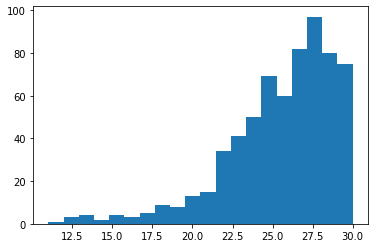

In [80]:
plt.hist(pdtab['MMSE'],bins=20)

## Fold 1

In [8]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn0/epoch16/"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/whole"

In [9]:
preds1=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [10]:
preds1

,pred
168_S_6180_I983061.nii,0.326510
168_S_6467_I1034450.nii,0.281763
019_S_6315_I997787.nii,0.777421
128_S_0135_I192851.nii,0.032233
041_S_1411_I76843.nii,0.277840
...,...
037_S_6222_I1021093.nii,0.002327
130_S_6612_I1092135.nii,0.015833
057_S_1265_I39726.nii,0.637943
135_S_6622_I1080300.nii,0.343843


In [ ]:
fold1=pd.concat([pdtab, preds1], axis=0)

In [75]:
fold1=fold1.dropna()

In [80]:
fold1

,MMSE,pred
073_S_0746_I413029.nii,27.0,NaN
073_S_0746_I285319.nii,27.0,NaN
073_S_0746_I117121.nii,29.0,NaN
073_S_0746_I135520.nii,30.0,NaN
073_S_0746_I165634.nii,30.0,NaN
...,...,...
037_S_6222_I1021093.nii,NaN,0.002327
130_S_6612_I1092135.nii,NaN,0.015833
057_S_1265_I39726.nii,NaN,0.637943
135_S_6622_I1080300.nii,NaN,0.343843


## Fold 2

In [11]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn1/epoch19"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/whole"

In [12]:
preds2=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [29]:
preds2

,pred
033_S_0906_I27135.nii,0.766828
109_S_6221_I1122085.nii,0.230480
341_S_6605_I1080531.nii,0.318953
341_S_6686_I1147777.nii,0.431770
003_S_6432_I1024803.nii,0.186854
...,...
109_S_6373_I1122764.nii,0.103469
041_S_1260_I43223.nii,0.608228
127_S_6241_I1007624.nii,0.228495
109_S_6220_I1122762.nii,0.141338


In [30]:
fold2=pd.concat([pdtab, preds2], axis=1)

In [31]:
fold2=fold2.dropna()

In [32]:
fold2

,MMSE,pred
126_S_1077_I35544.nii,17.0,0.281482
037_S_0377_I217256.nii,28.0,0.024987
141_S_1052_I286096.nii,22.0,0.219785
003_S_1074_I171424.nii,27.0,0.098875
012_S_0720_I23221.nii,30.0,0.850777
031_S_0294_I26400.nii,27.0,0.144389
027_S_0307_I256050.nii,30.0,0.026979
053_S_0919_I267656.nii,29.0,0.079820
141_S_1255_I227044.nii,25.0,0.756198
130_S_0285_I225718.nii,28.0,0.122263


## Fold 3

In [13]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn2/epoch17"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/whole"

In [14]:
preds3=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [35]:
preds3

,pred
041_S_1423_I73983.nii,0.766843
141_S_1378_I55188.nii,0.176701
941_S_6803_I1238836.nii,0.813478
027_S_6463_I1062326.nii,0.273875
168_S_6875_I1364446.nii,0.025107
...,...
305_S_6744_I1209690.nii,0.100661
099_S_6632_I1117860.nii,0.033862
051_S_6719_I1184831.nii,0.491081
031_S_0867_I208290.nii,0.341576


In [36]:
fold3=pd.concat([pdtab, preds3], axis=1)

In [37]:
fold3=fold3.dropna()

In [38]:
fold3

,MMSE,pred
003_S_1122_I222882.nii,26.0,0.214708
128_S_1408_I200599.nii,30.0,0.153672
016_S_1117_I183352.nii,19.0,0.619654
033_S_1116_I205053.nii,24.0,0.770155
114_S_0378_I29035.nii,29.0,0.302051
128_S_0770_I152809.nii,29.0,0.056245
037_S_1078_I209206.nii,27.0,0.831970
029_S_1218_I221994.nii,27.0,0.264127
003_S_0908_I223689.nii,30.0,0.084422
052_S_0989_I213447.nii,28.0,0.106912


## Fold 4

In [15]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn3/epoch22"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/whole"

In [16]:
preds4=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [41]:
preds4

,pred
109_S_1114_I35600.nii,0.461728
035_S_0997_I36328.nii,0.601928
114_S_1106_I33508.nii,0.021414
005_S_6427_I1029563.nii,0.024037
098_S_6707_I1192255.nii,0.048404
...,...
002_S_1268_I228411.nii,0.672856
128_S_1043_I272435.nii,0.950719
137_S_0669_I23219.nii,0.445485
037_S_6125_I961087.nii,0.001529


In [42]:
fold4=pd.concat([pdtab, preds4], axis=1)

In [43]:
fold4=fold4.dropna()

In [44]:
fold4

,MMSE,pred
100_S_0930_I53036.nii,27.0,0.921091
037_S_0566_I260904.nii,24.0,0.980763
007_S_0128_I20483.nii,27.0,0.817119
128_S_0225_I200597.nii,29.0,0.120248
941_S_1295_I69881.nii,25.0,0.559842
130_S_0289_I228746.nii,22.0,0.615156
052_S_0671_I243795.nii,21.0,0.988830
128_S_1043_I272435.nii,23.0,0.950719
027_S_0644_I242306.nii,26.0,0.172171
109_S_1343_I78293.nii,30.0,0.412680


## Fold 5

In [17]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn4/epoch9"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/whole"

In [18]:
preds5=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

In [47]:
preds5

,pred
012_S_1033_I31433.nii,0.329594
067_S_6529_I1059604.nii,0.614017
012_S_6073_I916397.nii,0.327386
305_S_6845_I1286989.nii,0.166181
037_S_0552_I240801.nii,0.990655
...,...
136_S_0107_I239482.nii,0.013534
033_S_6497_I1025067.nii,0.646371
068_S_0872_I282989.nii,0.035844
341_S_6764_I1218966.nii,0.167272


In [48]:
fold5=pd.concat([pdtab, preds5], axis=1)

In [49]:
fold5=fold5.dropna()

In [50]:
fold5.index

Index(['100_S_0296_I240472.nii', '014_S_0658_I202817.nii',
       '137_S_0668_I194243.nii', '052_S_1352_I232217.nii',
       '029_S_1318_I141742.nii', '031_S_0830_I194250.nii',
       '100_S_0892_I51323.nii', '021_S_0141_I20254.nii',
       '128_S_0227_I312075.nii', '141_S_1245_I108910.nii',
       '018_S_0080_I11044.nii', '136_S_0107_I239482.nii',
       '002_S_0729_I187916.nii', '068_S_0872_I282989.nii',
       '003_S_1057_I223690.nii'],
      dtype='object')

# Unite all Folds

In [19]:
preds=pd.concat([preds1, preds2,preds3,preds4,preds5])

In [20]:
preds

,pred
168_S_6180_I983061.nii,0.326510
168_S_6467_I1034450.nii,0.281763
019_S_6315_I997787.nii,0.777421
128_S_0135_I192851.nii,0.032233
041_S_1411_I76843.nii,0.277840
...,...
136_S_0107_I239482.nii,0.013534
033_S_6497_I1025067.nii,0.646371
068_S_0872_I282989.nii,0.035844
341_S_6764_I1218966.nii,0.167272


In [21]:
predsmmse=pd.concat((preds,pdtab),axis=1)

In [22]:
predsmmse=predsmmse.dropna(subset=['pred'])

In [23]:
predsmmse

,pred,MMSE
168_S_6180_I983061.nii,0.326510,NaN
168_S_6467_I1034450.nii,0.281763,NaN
019_S_6315_I997787.nii,0.777421,NaN
128_S_0135_I192851.nii,0.032233,NaN
041_S_1411_I76843.nii,0.277840,NaN
...,...,...
136_S_0107_I239482.nii,0.013534,28.0
033_S_6497_I1025067.nii,0.646371,NaN
068_S_0872_I282989.nii,0.035844,26.0
341_S_6764_I1218966.nii,0.167272,NaN


folds=pd.concat([fold1, fold2,fold3,fold4,fold5])

folds

In [24]:
a=list(predsmmse.index)

In [25]:
newa=[]
for i in a:
    i=i[:10]
    newa.append(i)

In [26]:
b=predsmmse['MMSE']
c=predsmmse['pred']

In [27]:
newpredsmmse=pd.DataFrame(list(zip(b, c)),
               columns =['MMSE', 'pred'], index=newa)

In [31]:
newpredsmmse

,MMSE,pred
168_S_6180,NaN,0.326510
168_S_6467,NaN,0.281763
019_S_6315,NaN,0.777421
128_S_0135,NaN,0.032233
041_S_1411,NaN,0.277840
...,...,...
136_S_0107,28.0,0.013534
033_S_6497,NaN,0.646371
068_S_0872,26.0,0.035844
341_S_6764,NaN,0.167272


In [29]:
cd /local_mount/space/celer/1/users/notebooks/moises/

/local_mount/space/celer/1/users/notebooks/moises


In [30]:
newpredsmmse.to_excel("5folds_preds&MMSE.xlsx")

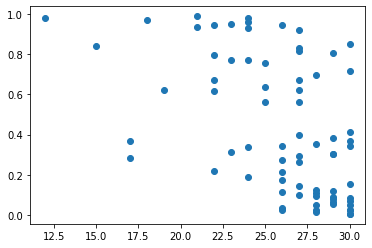

In [34]:
pyplot.scatter(newpredsmmse['MMSE'],newpredsmmse['pred'])

In [37]:
from scipy.stats import pearsonr
corr, pvalue= pearsonr(newpredsmmse.dropna()['MMSE'],newpredsmmse.dropna()['pred'])

In [38]:
print("Pearson's Correlation:",100*corr,"pvalue:",pvalue)

Pearson's Correlation: -51.76856304384829 pvalue: 2.3191844964587876e-06


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [43]:
x=newpredsmmse.dropna()['MMSE']
y=newpredsmmse.dropna()['pred']

In [44]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

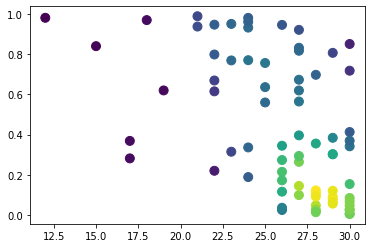

In [45]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=80)
plt.show()

In [46]:
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

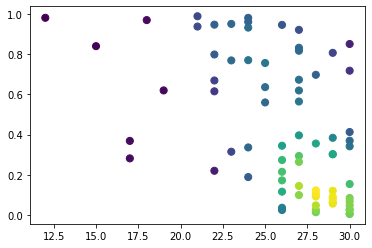

In [48]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()